In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

import cv2
import numpy as np
import pandas as pd
import random as rn
from time import time as t
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
if 'Data' not in os.listdir():
    os.mkdir('Data')
    shutil.copy('/content/drive/My Drive/19_Trasfer Learning/rvl-cdip.rar', '/content/Data')

In [ ]:
os.chdir("/content/Data")
if len(os.listdir())==1:
    !pip install unrar
    !unrar x '/content/Data/rvl-cdip.rar'

In [4]:
df = pd.read_csv("./labels_final.csv")
df['label'] = df['label'].astype(str)

os.chdir("/content/Data/data_final")
!rm -rf ./logs/ 

imagesk/k/e/u/keu70c00/2078716460.tif


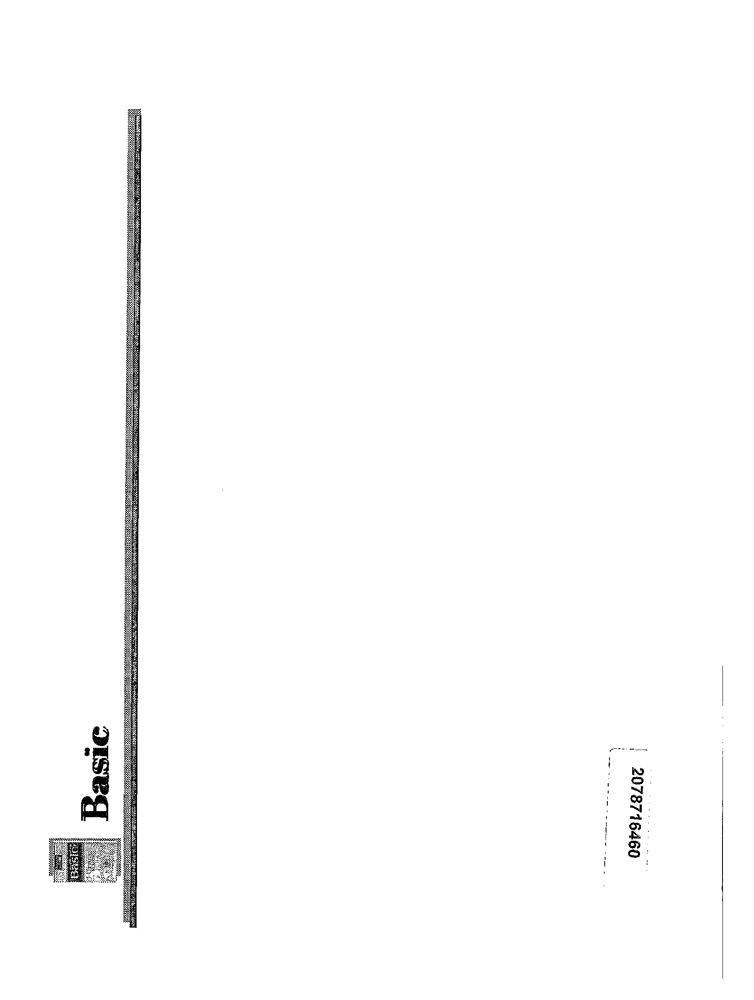

In [5]:
r = rn.randint(0, len(df))
img = cv2.imread(df['path'].iloc[r], cv2.IMREAD_UNCHANGED)
print(df['path'].iloc[r])
cv2_imshow(img)

In [6]:
##Getting size of images (taking 10 fr approx)
list_of_heights = []
list_of_widths = []
for i in trange(10):
    try:
        img = cv2.imread(df['path'].iloc[i], cv2.IMREAD_UNCHANGED)
        shape = img.shape  # get dimensions of image
        list_of_heights.append(shape[0])
        list_of_widths.append(shape[1])  
    except : print('skipping') ; continue
len(list_of_heights), len(list_of_widths), np.mean(list_of_heights), np.mean(list_of_widths)

100%|██████████| 10/10 [00:00<00:00, 359.88it/s]


(10, 10, 1000.0, 765.3)

## ImageDataGenerator

Target size is set as one third of the original size approximately, without altering the aspect ratio so that information is retained upto maximum extent. 

In [7]:
#@title Random selection of Train & Test 
##n = len(df) ; m = int(n*0.8)
#tr_ind = rn.sample(range(n), m)
#te_ind = [i for i in range(n) if i not in tr_ind]
#Train = df.iloc[tr_ind]
#Test = df.iloc[te_ind]
##len(Train), len(Test)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,
                                   zoom_range=0.2, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
s = t()
Train_Gen = train_datagen.flow_from_dataframe(df[:40000], x_col='path', y_col='label', 
                                              target_size=[224,224])
Test_Gen = test_datagen.flow_from_dataframe(df[40000:], x_col='path', y_col='label', 
                                            shuffle=False, target_size=[224,224])
print('Time elaped : ', t()-s)

Found 40000 validated image filenames belonging to 16 classes.
Found 8000 validated image filenames belonging to 16 classes.
Time elaped :  0.4857182502746582


## Building The Model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, ZeroPadding2D

In [11]:
Opt = tf.keras.optimizers.RMSprop()
CB = [TensorBoard('./logs', 1), 
      ReduceLROnPlateau(patience=2), 
      EarlyStopping(patience=3, restore_best_weights=True)]

## Model - 1 (VGG-16 without Top layers)

In [21]:
My_Model = None
My_Model = tf.keras.Sequential(
       [Input(shape=(224, 224,3)),
        VGG16(weights='imagenet',  include_top=False, ),
        ZeroPadding2D((1,1)),
        Conv2D(512, 3, 3, activation='relu'),
        MaxPool2D((2,2), strides=(2,2)), 
        Flatten(name='flatten'), 
        Dense(4096, activation='relu', name='fc1'), 
        Dense(256, activation='relu', name='fc2'), 
        Dense(16, activation='softmax', name='predictions')
        ])

My_Model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 9, 9, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         2359808   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              2101248   
_________________________________________________________________
fc2 (Dense)                  (None, 256)              

In [13]:
My_Model.compile(Opt,'categorical_crossentropy', metrics=['categorical_accuracy'])

with tf.device('/device:GPU:0'):
    My_Model.fit(Train_Gen, epochs=10, callbacks=CB, validation_data=Test_Gen)


Epoch 1/10
   1/1250 [..............................] - ETA: 0s - loss: 2.8353 - categorical_accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1250/1250 [==============================] - 586s 469ms/step - loss: 15.2795 - categorical_accuracy: 0.0659 - val_loss: 2.7732 - val_categorical_accuracy: 0.0608
Epoch 2/10
1250/1250 [==============================] - 571s 457ms/step - loss: 2.7197 - categorical_accuracy: 0.1206 - val_loss: 2.6450 - val_categorical_accuracy: 0.1444
Epoch 3/10
1250/1250 [==============================] - 578s 462ms/step - loss: 2.1919 - categorical_accuracy: 0.3153 - val_loss: 1.7166 - val_categorical_accuracy: 0.4563
Epoch 4/10
1250/1250 [==============================] - 585s 468ms/step - loss: 1.6781 - categorical_accura

In [22]:
!tensorboard dev upload --logdir ./logs/ \
  --name "Simple experiment for Transfer_Learning Assign" \
  --description "Training results from https://colab.research.google.com/drive/1LHL7m33LsdPOeAvCz9FjYb26xBzUmuJE?authuser=1#scrollTo=vhildlGRbEhI" \
  --one_shot

2020-09-21 11:01:40.412447: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/AyEfjGLORiOo9qZUrhdrxA/

[2020-09-21T11:01:42] Uploader started.
E0921 11:01:44.4363

## Model -2 

In [15]:
My_Model_2 = None
My_Model_2 = tf.keras.Sequential(
    [Input(shape=(224, 224,3)),
     VGG16(weights='imagenet', include_top=False),
     ZeroPadding2D((1,1)),
     Conv2D(512, 3, 3, activation='relu', ),
     MaxPool2D((2,2), strides=(2,2)), 
     Conv2D(1024, (1,1),  activation='relu', name = 'f2c1'), 
     Conv2D(1024, 1, activation='relu', name = 'f2c2'), 
     Flatten(name='flatten'), 
     Dense(16, activation='softmax', name='predictions')
     ])

My_Model_2.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 9, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 512)         2359808   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
f2c1 (Conv2D)                (None, 1, 1, 1024)        525312    
_________________________________________________________________
f2c2 (Conv2D)                (None, 1, 1, 1024)        1049600   
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [16]:
My_Model_2.compile(Opt,'categorical_crossentropy', metrics=['categorical_accuracy'])
        
with tf.device('/device:GPU:0'):
    My_Model_2.fit(Train_Gen, epochs=10, callbacks=CB, validation_data=Test_Gen)

Epoch 1/10
1250/1250 [==============================] - 581s 465ms/step - loss: 1.5547 - categorical_accuracy: 0.5194 - val_loss: 1.2473 - val_categorical_accuracy: 0.6116
Epoch 2/10
1250/1250 [==============================] - 573s 459ms/step - loss: 1.1765 - categorical_accuracy: 0.6430 - val_loss: 1.0953 - val_categorical_accuracy: 0.6604
Epoch 3/10
1250/1250 [==============================] - 569s 455ms/step - loss: 1.0321 - categorical_accuracy: 0.6904 - val_loss: 0.9813 - val_categorical_accuracy: 0.7007
Epoch 4/10
1250/1250 [==============================] - 576s 461ms/step - loss: 0.9379 - categorical_accuracy: 0.7179 - val_loss: 0.9275 - val_categorical_accuracy: 0.7168
Epoch 5/10
1250/1250 [==============================] - 568s 454ms/step - loss: 0.8678 - categorical_accuracy: 0.7390 - val_loss: 0.9196 - val_categorical_accuracy: 0.7246
Epoch 6/10
1250/1250 [==============================] - 575s 460ms/step - loss: 0.8155 - categorical_accuracy: 0.7516 - val_loss: 0.8470 - v

In [17]:
!tensorboard dev upload --logdir ./logs/ \
  --name "Simple experiment for Transfer_Learning Assign" \
  --description "Training results from https://colab.research.google.com/drive/1LHL7m33LsdPOeAvCz9FjYb26xBzUmuJE?authuser=1#scrollTo=vhildlGRbEhI" \
  --one_shot

2020-09-21 09:08:33.376488: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/wqWZSDLtRZWke0pnwf9r7Q/

[2020-09-21T09:08:35] Uploader started.
E0921 09:08:37.1859

## Model - 3

In [18]:
My_Model_3 = None ; My_Top_Model = None

VGG_in = VGG16(include_top=False, input_tensor = Input(shape=(224,224,3)))

My_Top_Model = tf.keras.Sequential(
    [ZeroPadding2D((1,1)),
     Conv2D(512, 3, 3, activation='relu', ),
     MaxPool2D((2,2), strides=(2,2)), 
     Conv2D(1024, (1,1),  activation='relu', name = 'f2c1'), 
     Conv2D(1024, 1, activation='relu', name = 'f2c2'), 
     Flatten(name='flatten'), 
     Dense(16, activation='softmax', name='predictions')
     ])

My_Model_3 = tf.keras.Sequential()
for l in VGG_in.layers:
    My_Model_3.add(l)

My_Model_3.add(My_Top_Model)

for layer in My_Model_3.layers[:10]:
    layer.trainable = False

My_Model_3.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [19]:
My_Model_3.compile(Opt,'categorical_crossentropy', metrics=['categorical_accuracy'])

with tf.device('/device:GPU:0'):
    My_Model_3.fit(Train_Gen, epochs=10, callbacks=CB, validation_data=Test_Gen)

Epoch 1/10
1250/1250 [==============================] - 590s 472ms/step - loss: 2.4150 - categorical_accuracy: 0.2718 - val_loss: 1.8673 - val_categorical_accuracy: 0.4385
Epoch 2/10
1250/1250 [==============================] - 585s 468ms/step - loss: 1.6958 - categorical_accuracy: 0.4886 - val_loss: 1.5150 - val_categorical_accuracy: 0.5320
Epoch 3/10
1250/1250 [==============================] - 579s 463ms/step - loss: 1.4985 - categorical_accuracy: 0.5447 - val_loss: 1.3836 - val_categorical_accuracy: 0.5798
Epoch 4/10
1250/1250 [==============================] - 586s 469ms/step - loss: 1.3975 - categorical_accuracy: 0.5778 - val_loss: 1.3108 - val_categorical_accuracy: 0.6070
Epoch 5/10
1250/1250 [==============================] - 583s 466ms/step - loss: 1.3286 - categorical_accuracy: 0.5995 - val_loss: 1.2667 - val_categorical_accuracy: 0.6146
Epoch 6/10
1250/1250 [==============================] - 583s 466ms/step - loss: 1.2747 - categorical_accuracy: 0.6155 - val_loss: 1.2111 - v

In [20]:
!tensorboard dev upload --logdir ./logs/ \
  --name "Simple experiment for Transfer_Learning Assign" \
  --description "Training results from https://colab.research.google.com/drive/1LHL7m33LsdPOeAvCz9FjYb26xBzUmuJE?authuser=1#scrollTo=vhildlGRbEhI" \
  --one_shot

2020-09-21 10:45:39.951614: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/LkiGBqvJQmOoldD6auKSJg/

[2020-09-21T10:45:41] Uploader started.
E0921 10:45:44.0309